In [1]:
import pandas as pd
from IPython.display import display_html
import seaborn as sns
import matplotlib.pyplot as plt

COUNTRIES = ['ENG', 'FRA', 'GER', 'ITA', 'SPA']

In [2]:
actual_dfs = {}

for country in COUNTRIES:
    actual_dfs[country] = pd.read_csv(f'./data/machine_learning/tables/{country}_2023.csv')

In [3]:
# Display tables side by side
def display_side_by_side(*args, spacing=10):
    html_str = ''
    for df in args:
        html_str += df.to_html()
        html_str += '<span style="margin-right: {}px;"></span>'.format(spacing)
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

In [4]:
# HELPER FUNCTIONS
def assign_points_and_outcome(row):
    if row['home_predicted_result'] == 'W':
        return pd.Series([3, 0, 'W', 'L']) # home win
    elif row['home_predicted_result'] == 'L':
        return pd.Series([0, 3, 'L', 'W'])  # home loss
    else:
        return pd.Series([1, 1, 'D', 'D'])  # draw
    
def count_results(series, result):
    return (series == result).sum()

def outcome_count(series):
    return pd.Series({'W': (series == 'W').sum(), 'D': (series == 'D').sum(), 'L': (series == 'L').sum()})

In [5]:
def print_all_tables_for_model(model):
    df = pd.read_csv(f'data/machine_learning/predictions/{model}.csv')
    home_df = df[df['is_home'] == 1].copy()
    away_df = df[df['is_home'] == 0].copy()
    home_df['match_id'] = home_df.apply(lambda x: '_'.join([str(x['team']), str(x['opponent'])]), axis=1)
    away_df['match_id'] = away_df.apply(lambda x: '_'.join([str(x['opponent']), str(x['team'])]), axis=1)
    home_df = home_df.rename(columns={'team_country': 'country', 'team': 'home_team', 'opponent': 'away_team', 'predicted_result': 'home_predicted_result'}).drop(['is_home'], axis=1)
    away_df['predicted_result'].replace({'W': 'L', 'L': 'W'}, inplace=True)
    away_df = away_df.rename(columns={'team_country': 'country', 'team': 'away_team', 'opponent': 'home_team', 'predicted_result': 'home_predicted_result'}).drop(['is_home'], axis=1)

    # merge on outer to get conflicting outcomes
    full_game_df = pd.merge(home_df, away_df, how='outer')

    # set these games to take a random result
    full_game_df = full_game_df.groupby(['match_id']).apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    # Apply the modified function
    full_game_df[['home_points', 'away_points', 'home_outcome', 'away_outcome']] = full_game_df.apply(assign_points_and_outcome, axis=1)

    # Preparing data for grouping with outcomes
    home_games = full_game_df[['country', 'home_team', 'home_points', 'home_outcome']].rename(
        columns={'home_team': 'TEAM', 'home_points': 'points', 'home_outcome': 'outcome'})
    away_games = full_game_df[['country', 'away_team', 'away_points', 'away_outcome']].rename(
        columns={'away_team': 'TEAM', 'away_points': 'points', 'away_outcome': 'outcome'})

    # Concatenating home and away games
    all_games = pd.concat([home_games, away_games])

    # Grouping by country and team and calculating total points, matches played, wins, draws, and losses
    league_table = all_games.groupby(['country', 'TEAM']).agg(
        MP=pd.NamedAgg(column='points', aggfunc='size'),
        W=pd.NamedAgg(column='outcome', aggfunc=lambda x: count_results(x, 'W')),
        D=pd.NamedAgg(column='outcome', aggfunc=lambda x: count_results(x, 'D')),
        L=pd.NamedAgg(column='outcome', aggfunc=lambda x: count_results(x, 'L')),
        PTS=pd.NamedAgg(column='points', aggfunc='sum'),
    ).sort_values(by=['country', 'PTS'], ascending=[True, False])

    for country, country_group in league_table.groupby(level='country'):
        print(f"League Table for {country} (Predicted vs Actual):")
        # Reset the index for the current group to make 'team' a regular column again
        country_group = country_group.reset_index(level='country', drop=True).reset_index()
        country_group.index = country_group.index + 1
        
        actual_df = actual_dfs[country].copy()
        actual_df.index = actual_df.index + 1

        display_side_by_side(country_group[['TEAM', 'MP', 'W', 'D', 'L', 'PTS']], actual_df)
        print("\n")

### Use `print_all_tables_for_model()` on any of the following models:

- `LogisticRegression`
- `DecisionTreeClassifier`
- `RandomForestClassifier`
- `ExtraTreesClassifier`
- `GradientBoostingClassifier`
- `GaussianNB`
- `KNeighborsClassifier`
- `SVC`

## Logistic Regression

Strong teams rarely draw, weakest teams are usually winless

In [6]:
print_all_tables_for_model('LogisticRegression')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,36,0,2,108
3,Manchester Utd,38,32,1,5,97
4,Liverpool,38,32,0,6,96
5,Chelsea,38,26,6,6,84
6,Tottenham,38,24,3,11,75
7,Newcastle,38,23,4,11,73
8,Brighton,38,23,3,12,72
9,West Ham,38,15,11,12,56
10,Brentford,38,10,10,18,40




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Rennes,34,28,0,6,84
3,Monaco,34,26,2,6,80
4,Marseille,34,25,4,5,79
5,Lens,34,26,0,8,78
6,Lyon,34,19,8,7,65
7,Lille,34,18,7,9,61
8,Nice,34,11,15,8,48
9,Metz,34,9,10,15,37
10,Reims,34,7,15,12,36




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,Dortmund,34,30,0,4,90
3,RB Leipzig,34,30,0,4,90
4,Bayer Leverkusen,34,26,2,6,80
5,Eintracht Frankfurt,34,20,5,9,65
6,Union Berlin,34,20,3,11,63
7,Freiburg,34,14,7,13,49
8,Mainz,34,12,10,12,46
9,Hoffenheim,34,8,14,12,38
10,Heidenheim,34,12,1,21,37




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,37,0,1,111
2,Inter,38,35,0,3,105
3,AC Milan,38,34,0,4,102
4,Juventus,38,31,2,5,95
5,Atalanta,38,21,7,10,70
6,AS Roma,38,20,9,9,69
7,Torino,38,19,9,10,66
8,Fiorentina,38,20,5,13,65
9,Lazio,38,14,12,12,54
10,Bologna,38,10,13,15,43




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,37,0,1,111
2,Real Madrid,38,37,0,1,111
3,Atl. Madrid,38,32,1,5,97
4,Real Sociedad,38,26,7,5,85
5,Ath Bilbao,38,14,17,7,59
6,Villarreal,38,14,17,7,59
7,Sevilla,38,12,18,8,54
8,Osasuna,38,7,20,11,41
9,Celta Vigo,38,5,22,11,37
10,Valencia,38,4,25,9,37


## Decision Tree

Results seem to be quite possible, apart from draws being quite random

In [7]:
print_all_tables_for_model('DecisionTreeClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,30,4,4,94
2,Arsenal,38,29,1,8,88
3,Chelsea,38,18,8,12,62
4,Aston Villa,38,17,9,12,60
5,Manchester Utd,38,17,8,13,59
6,Everton,38,15,12,11,57
7,Brentford,38,17,5,16,56
8,Fulham,38,17,5,16,56
9,Newcastle,38,14,11,13,53
10,West Ham,38,15,8,15,53




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Strasbourg,34,15,12,7,57
3,Monaco,34,12,16,6,52
4,Rennes,34,13,13,8,52
5,Reims,34,14,9,11,51
6,Lille,34,12,14,8,50
7,Marseille,34,13,8,13,47
8,Brest,34,12,10,12,46
9,Lorient,34,12,10,12,46
10,Le Havre,34,9,16,9,43




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,26,5,3,83
2,Eintracht Frankfurt,34,20,8,6,68
3,Bayer Leverkusen,34,20,5,9,65
4,Bayern Munich,34,20,4,10,64
5,FC Koln,34,15,7,12,52
6,RB Leipzig,34,13,12,9,51
7,Darmstadt,34,14,6,14,48
8,Freiburg,34,13,9,12,48
9,Hoffenheim,34,13,8,13,47
10,Union Berlin,34,12,9,13,45




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Inter,38,26,5,7,83
2,AC Milan,38,25,6,7,81
3,Juventus,38,24,6,8,78
4,Torino,38,20,11,7,71
5,Fiorentina,38,20,9,9,69
6,AS Roma,38,20,8,10,68
7,Napoli,38,20,7,11,67
8,Atalanta,38,16,12,10,60
9,Empoli,38,13,10,15,49
10,Salernitana,38,12,13,13,49




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,23,13,2,82
2,Real Madrid,38,23,7,8,76
3,Real Sociedad,38,20,6,12,66
4,Valencia,38,18,12,8,66
5,Atl. Madrid,38,18,10,10,64
6,Villarreal,38,17,12,9,63
7,Ath Bilbao,38,16,12,10,60
8,Sevilla,38,14,15,9,57
9,Betis,38,14,14,10,56
10,Rayo Vallecano,38,11,16,11,49


## Random Forest

Strong teams never draw

In [8]:
print_all_tables_for_model('RandomForestClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,34,0,4,102
3,Brighton,38,30,0,8,90
4,Newcastle,38,30,0,8,90
5,Liverpool,38,28,0,10,84
6,Chelsea,38,25,0,13,75
7,Manchester Utd,38,25,0,13,75
8,Tottenham,38,24,0,14,72
9,Brentford,38,20,0,18,60
10,West Ham,38,17,0,21,51




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Lens,34,28,1,5,85
3,Rennes,34,28,0,6,84
4,Monaco,34,26,0,8,78
5,Marseille,34,25,0,9,75
6,Lyon,34,24,1,9,73
7,Lille,34,23,1,10,70
8,Nice,34,22,0,12,66
9,Metz,34,13,3,18,42
10,Strasbourg,34,10,7,17,37




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,33,0,1,99
2,Bayern Munich,34,32,0,2,96
3,RB Leipzig,34,29,0,5,87
4,Bayer Leverkusen,34,27,1,6,82
5,Eintracht Frankfurt,34,27,0,7,81
6,Freiburg,34,24,1,9,73
7,Union Berlin,34,16,2,16,50
8,Hoffenheim,34,14,2,18,44
9,Wolfsburg,34,12,2,20,38
10,Werder Bremen,34,10,5,19,35




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,36,0,2,108
2,Juventus,38,35,0,3,105
3,AC Milan,38,33,1,4,100
4,Inter,38,33,0,5,99
5,Lazio,38,30,0,8,90
6,Atalanta,38,25,2,11,77
7,Fiorentina,38,25,0,13,75
8,AS Roma,38,24,1,13,73
9,Torino,38,19,2,17,59
10,Sassuolo,38,16,3,19,51




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,37,0,1,111
2,Atl. Madrid,38,35,1,2,106
3,Real Madrid,38,35,0,3,105
4,Real Sociedad,38,31,0,7,93
5,Villarreal,38,27,2,9,83
6,Ath Bilbao,38,23,2,13,71
7,Sevilla,38,20,2,16,62
8,Valencia,38,20,0,18,60
9,Girona,38,16,3,19,51
10,Getafe,38,13,7,18,46


## Extra Trees

Strong teams rarely draw, weakest teams are sometimes winless

In [9]:
print_all_tables_for_model('ExtraTreesClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,37,0,1,111
2,Arsenal,38,34,1,3,103
3,Newcastle,38,31,0,7,93
4,Brighton,38,28,0,10,84
5,Liverpool,38,28,0,10,84
6,Manchester Utd,38,28,0,10,84
7,Tottenham,38,23,0,15,69
8,Chelsea,38,20,1,17,61
9,Brentford,38,18,1,19,55
10,West Ham,38,18,0,20,54




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,33,0,1,99
2,Lens,34,28,1,5,85
3,Rennes,34,27,1,6,82
4,Lyon,34,26,0,8,78
5,Lille,34,23,1,10,70
6,Monaco,34,23,1,10,70
7,Marseille,34,22,2,10,68
8,Nice,34,20,3,11,63
9,Metz,34,11,2,21,35
10,Reims,34,8,9,17,33




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,31,0,3,93
2,Dortmund,34,30,1,3,91
3,RB Leipzig,34,30,0,4,90
4,Bayer Leverkusen,34,28,2,4,86
5,Eintracht Frankfurt,34,20,1,13,61
6,Freiburg,34,19,4,11,61
7,Stuttgart,34,17,5,12,56
8,Wolfsburg,34,17,0,17,51
9,Union Berlin,34,16,0,18,48
10,B. Monchengladbach,34,12,4,18,40




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Inter,38,36,1,1,109
2,Napoli,38,36,0,2,108
3,Juventus,38,32,0,6,96
4,AC Milan,38,31,0,7,93
5,Lazio,38,28,3,7,87
6,Fiorentina,38,26,0,12,78
7,Atalanta,38,24,2,12,74
8,AS Roma,38,20,4,14,64
9,Torino,38,19,4,15,61
10,Sassuolo,38,17,3,18,54




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,36,0,2,108
2,Real Madrid,38,36,0,2,108
3,Atl. Madrid,38,33,2,3,101
4,Real Sociedad,38,28,2,8,86
5,Ath Bilbao,38,27,1,10,82
6,Villarreal,38,27,1,10,82
7,Sevilla,38,21,4,13,67
8,Valencia,38,21,4,13,67
9,Osasuna,38,14,4,20,46
10,Celta Vigo,38,14,1,23,43


## Gradient Boosting

Strong teams rarely draw, weakest teams often winless

In [10]:
print_all_tables_for_model('GradientBoostingClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,37,0,1,111
2,Arsenal,38,35,0,3,105
3,Liverpool,38,35,0,3,105
4,Newcastle,38,31,0,7,93
5,Manchester Utd,38,30,0,8,90
6,Brighton,38,28,0,10,84
7,Tottenham,38,24,1,13,73
8,Chelsea,38,20,6,12,66
9,West Ham,38,14,9,15,51
10,Brentford,38,12,11,15,47




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,31,1,2,94
2,Monaco,34,24,7,3,79
3,Lyon,34,24,4,6,76
4,Lens,34,24,3,7,75
5,Marseille,34,23,4,7,73
6,Rennes,34,21,7,6,70
7,Lille,34,19,8,7,65
8,Nice,34,17,12,5,63
9,Montpellier,34,7,13,14,34
10,Metz,34,6,11,17,29




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,33,0,1,99
2,Bayern Munich,34,31,1,2,94
3,Bayer Leverkusen,34,29,0,5,87
4,Eintracht Frankfurt,34,27,1,6,82
5,RB Leipzig,34,26,3,5,81
6,Freiburg,34,11,15,8,48
7,Union Berlin,34,12,12,10,48
8,Wolfsburg,34,11,10,13,43
9,B. Monchengladbach,34,5,19,10,34
10,Hoffenheim,34,7,12,15,33




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,AC Milan,38,36,0,2,108
2,Inter,38,36,0,2,108
3,Napoli,38,36,0,2,108
4,Atalanta,38,27,5,6,86
5,Juventus,38,25,6,7,81
6,AS Roma,38,23,7,8,76
7,Lazio,38,17,12,9,63
8,Fiorentina,38,12,20,6,56
9,Torino,38,10,17,11,47
10,Bologna,38,9,12,17,39




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,38,0,0,114
2,Atl. Madrid,38,35,0,3,105
3,Real Madrid,38,35,0,3,105
4,Real Sociedad,38,27,5,6,86
5,Villarreal,38,20,11,7,71
6,Valencia,38,6,26,6,44
7,Ath Bilbao,38,6,24,8,42
8,Sevilla,38,6,24,8,42
9,Betis,38,4,26,8,38
10,Girona,38,7,17,14,38


### Naive Bayes

Strong teams never draw, while weak teams are always winless

In [11]:
print_all_tables_for_model('GaussianNB')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,36,0,2,108
3,Liverpool,38,34,0,4,102
4,Chelsea,38,32,0,6,96
5,Manchester Utd,38,30,0,8,90
6,Brighton,38,28,0,10,84
7,Newcastle,38,25,0,13,75
8,Tottenham,38,25,0,13,75
9,Burnley,38,20,0,18,60
10,West Ham,38,18,0,20,54




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Lens,34,32,0,2,96
3,Rennes,34,28,0,6,84
4,Lille,34,27,0,7,81
5,Lyon,34,25,0,9,75
6,Marseille,34,25,0,9,75
7,Monaco,34,24,0,10,72
8,Nice,34,19,1,14,58
9,Metz,34,16,1,17,49
10,Reims,34,11,4,19,37




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,Dortmund,34,32,0,2,96
3,Bayer Leverkusen,34,29,0,5,87
4,RB Leipzig,34,29,0,5,87
5,Stuttgart,34,23,0,11,69
6,Eintracht Frankfurt,34,21,3,10,66
7,Heidenheim,34,19,1,14,58
8,Freiburg,34,18,1,15,55
9,Wolfsburg,34,15,4,15,49
10,Darmstadt,34,12,7,15,43




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,38,0,0,114
2,Inter,38,36,0,2,108
3,AC Milan,38,33,0,5,99
4,Juventus,38,33,0,5,99
5,Fiorentina,38,27,0,11,81
6,Lazio,38,27,0,11,81
7,Torino,38,24,0,14,72
8,Udinese,38,24,0,14,72
9,AS Roma,38,23,0,15,69
10,Atalanta,38,23,0,15,69




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Real Madrid,38,38,0,0,114
2,Barcelona,38,36,0,2,108
3,Atl. Madrid,38,34,0,4,102
4,Villarreal,38,31,0,7,93
5,Ath Bilbao,38,28,0,10,84
6,Las Palmas,38,26,1,11,79
7,Girona,38,25,1,12,76
8,Real Sociedad,38,25,0,13,75
9,Sevilla,38,23,1,14,70
10,Mallorca,38,9,11,18,38


## K Neighbors

Seems to be the most reliable

In [12]:
print_all_tables_for_model('KNeighborsClassifier')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,36,2,0,110
2,Arsenal,38,31,3,4,96
3,Brighton,38,25,8,5,83
4,Manchester Utd,38,21,11,6,74
5,Tottenham,38,20,5,13,65
6,Newcastle,38,18,10,10,64
7,Liverpool,38,15,15,8,60
8,Chelsea,38,16,4,18,52
9,Aston Villa,38,13,11,14,50
10,West Ham,38,13,10,15,49




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,33,1,0,100
2,Lens,34,29,2,3,89
3,Lyon,34,20,7,7,67
4,Monaco,34,19,7,8,64
5,Marseille,34,16,11,7,59
6,Rennes,34,16,8,10,56
7,Metz,34,16,5,13,53
8,Lille,34,14,9,11,51
9,Reims,34,11,12,11,45
10,Le Havre,34,9,15,10,42




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Dortmund,34,27,1,6,82
2,Bayern Munich,34,24,2,8,74
3,Bayer Leverkusen,34,19,10,5,67
4,RB Leipzig,34,19,9,6,66
5,Freiburg,34,16,9,9,57
6,Eintracht Frankfurt,34,12,11,11,47
7,FC Koln,34,11,14,9,47
8,Stuttgart,34,10,17,7,47
9,Werder Bremen,34,12,10,12,46
10,Union Berlin,34,9,16,9,43




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,AC Milan,38,30,6,2,96
2,Inter,38,30,3,5,93
3,Napoli,38,24,5,9,77
4,Juventus,38,21,8,9,71
5,Lazio,38,18,12,8,66
6,AS Roma,38,17,11,10,62
7,Fiorentina,38,12,13,13,49
8,Udinese,38,12,13,13,49
9,Sassuolo,38,12,10,16,46
10,Verona,38,11,13,14,46




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,31,4,3,97
2,Real Madrid,38,26,5,7,83
3,Atl. Madrid,38,23,10,5,79
4,Real Sociedad,38,18,10,10,64
5,Villarreal,38,14,13,11,55
6,Granada CF,38,14,12,12,54
7,Alaves,38,14,11,13,53
8,Ath Bilbao,38,14,11,13,53
9,Mallorca,38,11,17,10,50
10,Cadiz CF,38,12,13,13,49


## Support Vector

Strong teams never draw, while weak teams are always winless

In [13]:
print_all_tables_for_model('SVC')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,38,0,0,114
2,Arsenal,38,36,0,2,108
3,Liverpool,38,34,0,4,102
4,Newcastle,38,31,0,7,93
5,Brighton,38,30,1,7,91
6,Manchester Utd,38,24,1,13,73
7,West Ham,38,23,3,12,72
8,Tottenham,38,23,0,15,69
9,Chelsea,38,20,0,18,60
10,Aston Villa,38,18,2,18,56




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Lens,34,31,0,3,93
3,Rennes,34,29,0,5,87
4,Marseille,34,22,6,6,72
5,Monaco,34,21,7,6,70
6,Lille,34,20,3,11,63
7,Lyon,34,12,11,11,47
8,Metz,34,10,9,15,39
9,Strasbourg,34,6,18,10,36
10,Le Havre,34,7,13,14,34




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,34,0,0,102
2,Dortmund,34,32,0,2,96
3,Bayer Leverkusen,34,28,1,5,85
4,RB Leipzig,34,28,1,5,85
5,Eintracht Frankfurt,34,18,8,8,62
6,Freiburg,34,12,13,9,49
7,Mainz,34,11,11,12,44
8,Union Berlin,34,10,14,10,44
9,FC Koln,34,7,13,14,34
10,Wolfsburg,34,6,12,16,30




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,38,0,0,114
2,Inter,38,35,0,3,105
3,Juventus,38,33,0,5,99
4,AC Milan,38,30,3,5,93
5,AS Roma,38,19,12,7,69
6,Atalanta,38,17,14,7,65
7,Fiorentina,38,18,10,10,64
8,Lazio,38,16,11,11,59
9,Torino,38,12,15,11,51
10,Sassuolo,38,7,18,13,39




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Barcelona,38,38,0,0,114
2,Real Madrid,38,36,0,2,108
3,Atl. Madrid,38,33,0,5,99
4,Real Sociedad,38,25,8,5,83
5,Ath Bilbao,38,23,7,8,76
6,Sevilla,38,17,10,11,61
7,Villarreal,38,15,15,8,60
8,Valencia,38,7,23,8,44
9,Osasuna,38,6,22,10,40
10,Getafe,38,3,22,13,31


## LSTM Evaluation

Strong teams rarely draw, weakest teams are usually winless

In [14]:
print_all_tables_for_model('LSTM')

League Table for ENG (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Manchester City,38,35,3,0,108
2,Arsenal,38,32,5,1,101
3,Liverpool,38,30,6,2,96
4,Manchester Utd,38,30,5,3,95
5,Chelsea,38,29,3,6,90
6,Newcastle,38,24,6,8,78
7,Brighton,38,24,5,9,77
8,Tottenham,38,25,2,11,77
9,Aston Villa,38,15,9,14,54
10,West Ham,38,13,9,16,48




League Table for FRA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,PSG,34,34,0,0,102
2,Rennes,34,29,0,5,87
3,Lyon,34,27,0,7,81
4,Monaco,34,26,2,6,80
5,Marseille,34,25,1,8,76
6,Lille,34,24,2,8,74
7,Lens,34,23,3,8,72
8,Nice,34,16,8,10,56
9,Metz,34,5,14,15,29
10,Reims,34,5,14,15,29




League Table for GER (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Bayern Munich,34,33,1,0,100
2,Dortmund,34,30,3,1,93
3,RB Leipzig,34,30,1,3,91
4,Bayer Leverkusen,34,26,3,5,81
5,Eintracht Frankfurt,34,18,8,8,62
6,B. Monchengladbach,34,13,10,11,49
7,Wolfsburg,34,14,6,14,48
8,Freiburg,34,10,16,8,46
9,Stuttgart,34,7,15,12,36
10,Union Berlin,34,6,18,10,36




League Table for ITA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Napoli,38,35,3,0,108
2,Inter,38,33,3,2,102
3,AC Milan,38,32,5,1,101
4,Juventus,38,31,5,2,98
5,Atalanta,38,26,4,8,82
6,Fiorentina,38,24,4,10,76
7,AS Roma,38,24,3,11,75
8,Lazio,38,22,4,12,70
9,Torino,38,12,12,14,48
10,Udinese,38,13,7,18,46




League Table for SPA (Predicted vs Actual):


,TEAM,MP,W,D,L,PTS
1,Real Madrid,38,36,2,0,110
2,Barcelona,38,35,3,0,108
3,Atl. Madrid,38,34,1,3,103
4,Real Sociedad,38,29,1,8,88
5,Villarreal,38,27,4,7,85
6,Ath Bilbao,38,22,7,9,73
7,Sevilla,38,12,15,11,51
8,Girona,38,9,17,12,44
9,Betis,38,5,24,9,39
10,Valencia,38,4,22,12,34


## Observations

Comparing with `2023-24` data, most models used were `unable to predict draws`, especially for stronger teams. Moreover, many of provide results that are `too optimistic for the stronger teams` (almost 100% win rate), while being `too pessimistic for weaker teams` (almost 0% win rate)

At first glance, the models that seem to provide the most realistic results are in the order:

1. `KNeighborsClassifier` - Provides the most reliable results
2. `DecisionTreeClassifier` - Almost as reliable as KNeighborsClassifier, but draws are quite random
3. `ExtraTreesClassifier` - Strong teams rarely draw, weakest teams are sometimes winless
4. `LogisticRegression` - Strong teams rarely draw, weakest teams are usually winless
5. `LSTM` - Strong teams rarely draw, weakest teams are usually winless
6. `GradientBoostingClassifier` - Strong teams rarely draw, weakest teams often winless
7. `RandomForestClassifier` - Strong teams never draw
8. `SVC` - Strong teams never draw, while weak teams are always winless
9. `GaussianNB` - Strong teams never draw, while weak teams are always winless

### However, are they really the best models?

In [15]:
metrics_df = pd.read_csv('data/machine_learning/model_metrics.csv', index_col=0)
lstm_metrics_df = pd.read_csv('data/machine_learning/lstm_metrics.csv', index_col=0)

In [16]:
metrics_df.index

Index(['LogisticRegression', 'DecisionTreeClassifier',
       'RandomForestClassifier', 'ExtraTreesClassifier',
       'GradientBoostingClassifier', 'GaussianNB', 'KNeighborsClassifier',
       'SVC'],
      dtype='object')

In [17]:
all_metrics_df = pd.concat([metrics_df, lstm_metrics_df])
all_metrics_df

,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.502429,0.517026,0.502429,0.508562
DecisionTreeClassifier,0.422623,0.429767,0.422623,0.425801
RandomForestClassifier,0.475017,0.465172,0.475017,0.469144
ExtraTreesClassifier,0.490285,0.470735,0.490285,0.477558
GradientBoostingClassifier,0.500347,0.514223,0.500347,0.506310
GaussianNB,0.482304,0.492612,0.482304,0.486772
KNeighborsClassifier,0.443789,0.460676,0.443789,0.447938
SVC,0.498265,0.521564,0.498265,0.506950
LSTM,0.480832,0.494342,0.480832,0.486300


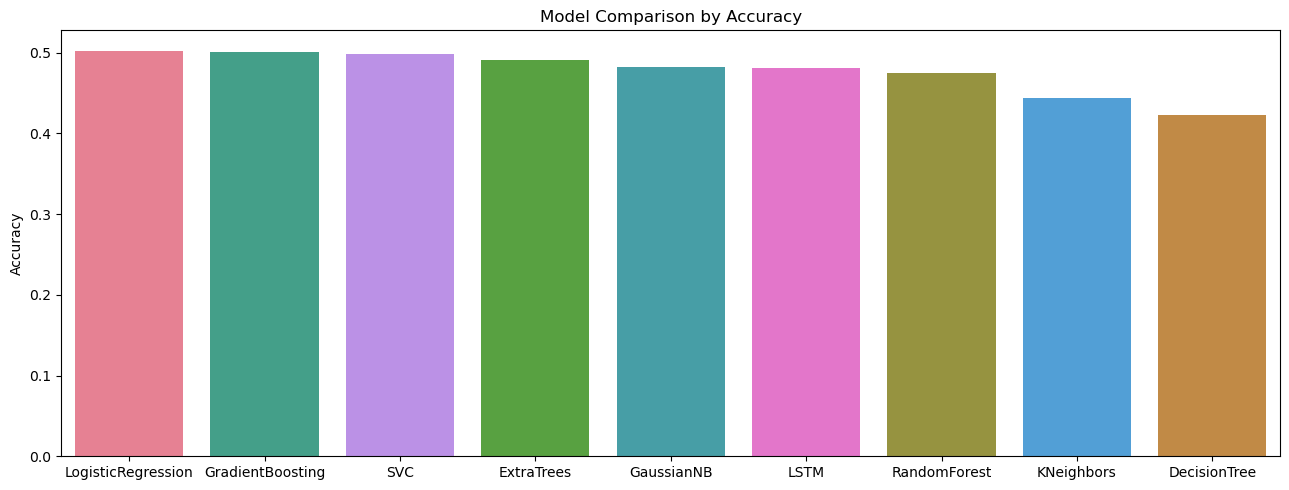

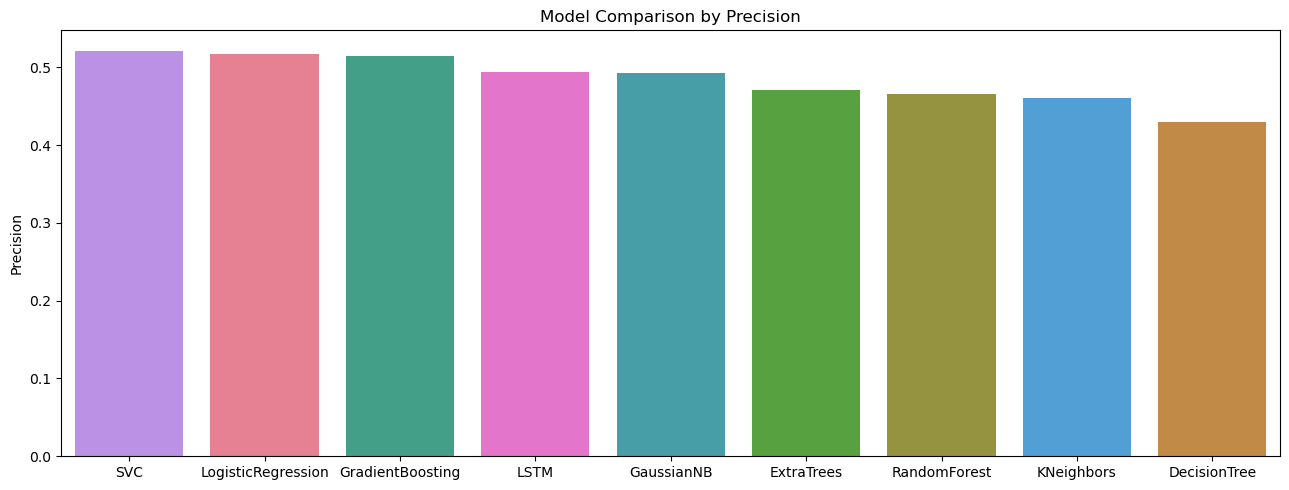

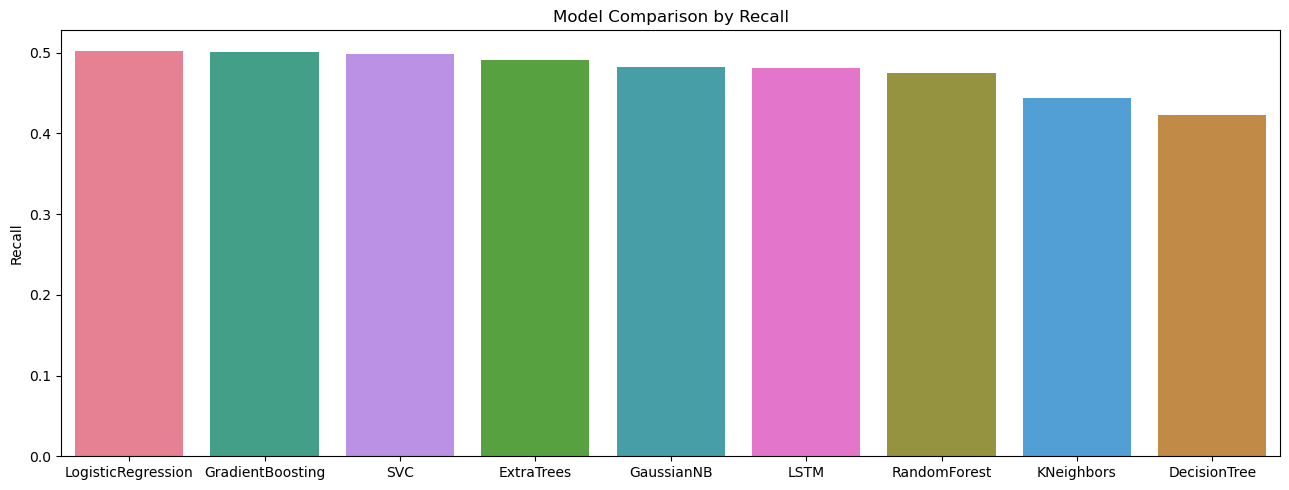

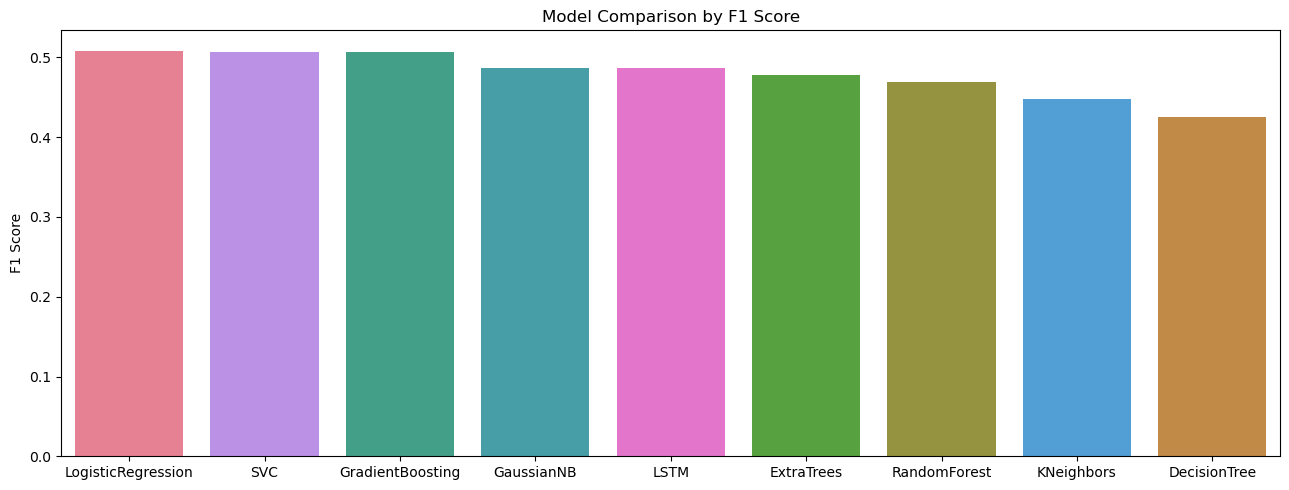

In [18]:
palette = sns.color_palette("husl", n_colors=len(all_metrics_df.index))
color_dict = dict(zip(all_metrics_df.index, palette))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for metric in metrics:
    sorted_df = all_metrics_df.sort_values(by=metric, ascending=False)
    hue_order = [name for name in sorted_df.index]

    # Create a clean figure for each metric
    fig, ax = plt.subplots(figsize=(13, 5))  # You can adjust the size as needed

    # Splitting classifier names for better readability
    sorted_class_names = [name.split('Classifier')[0] for name in sorted_df.index]
    sns.barplot(
        x=sorted_class_names, 
        y=sorted_df[metric],
        hue=hue_order,
        dodge=False,
        palette=color_dict,
        ax=ax
    )
    ax.get_legend().remove()  # Remove the legend to clean up the graph
    ax.set_title(f'Model Comparison by {metric}')
    ax.set_ylabel(metric)

    plt.tight_layout()
    plt.show()

<h5>The results go against our initial hypothesis!</h5>

In comparing the models based on `Accuracy`, `Precision`, `Recall`, and `F1-Score`, `KNeighbors` and `DecisionTree` actually performed the worst out of all the models. Meanwhile, `LogisticRegression` was the best model, even though it doesn't seem to predict draws very well...

The 3 `best` models are:
1. `LogisticRegression`
2. `SVC`
3. `GradientBoosting`

The 3 `worst` models are:
1. `DecisionTree`
2. `KNeighbours`
3. `RandomForest`

The deep learning `LSTM` model has average performance

## Conclusion

<h5>Draws are extremely difficult to predict</h5>

Even after using Logistic Regression to favor feature selection for draws compared to wins and losses in [03_feature_selection.ipynb](./03_feature_selection.ipynb), the models still perform poorly in predicting draws. Perhaps, due to it being less common than wins and losses, so there are less patterns that models can learn to effectively associate certain features with a draw. Yet, even after using a balanced sample weight in [04_machine_learning.ipynb](./04_machine_learning.ipynb), the model still performs poorly. It seems that draws might also involve higher levels of uncertainty and variability, or that the feaatures themselves are sensitive enough to the nuances that lead to draws.

<h5>Using previous season performance data is not a very good indicator for this current results</h5>

This is intuitive, as teams will sign new players during the transfer window after every season, hence using previous season performance does not take into account the capabilities of new players going into the season. Results have also proven to be unpredictable from the past, such as:
1. Leicester City's Premier League win in 2015-16, with defied pre-season odds of 5000:1.
2. Bayer Leverkusen's Bundesliga win this season in 2023-24, even though pre-season odds placed Bayer Leverkusen with a 50:1 chance of winning the Bundesliga​. 

<h5>How does the data show that DecisionTree and KNeighbors actually performed poorly?</h5>

When analysing the actual tables, the rankings of `DecisionTree` and `KNeighbours` often do not make sense as known weaker teams somehow place higher than known stronger teams. For example, `Manchester City`, and extremely dominant team in England, has been predicted to be outside of the top 5 on several runs. This suggests that *even though a model might have a good proportion of draws, it can still perform badly*. Moreover, it also highlights how a *single Decision Tree and K-Neighbors perform poorly when there are many features/dimensions* (we used over 20 features for our predictions) (Refer to the table in [04_machine_learning.ipynb](./04_machine_learning.ipynb)).

<h5>What do the better models ie. Logistic Regression, SVC and Gradient Boosting tell us?</h5>

*The significance of Wins and Losses outweighs a Draw*. Even though these models do not predict draws very well, their ability to accurately predict wins and losses make them the best models. Moreover, it also shows how *GradientBoosting (a Tree Ensemble algorithm) performs better than a single Decision Tree as it uses multiple trees to reduce overfitting and increase prediction accuracy* (Refer to the table in [04_machine_learning.ipynb](./04_machine_learning.ipynb)).

<h5>What does the models tell us about the nature of the data?</h5>

It seems that our data is **linear**, rather than non-linear (as hypothesised in [05_deep_learning.ipynb](./05_deep_learning.ipynb)). Perhaps, this is because our data for each **team performance for every game is the same** throughout the season. As such, the LSTM does not capture any significant patterns between the sequences to help it predict outcomes more accurately.
